In [1]:
import os
import csv
import scipy
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import episcanpy.api as epi
from sklearn.feature_extraction.text import TfidfTransformer
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = "retina"
os.chdir("..")

In [4]:
os.chdir("..")

In [5]:
adata = ad.read("data/P20057_1005/binned_5kb_count_matrix_K27me3.h5ad")

In [8]:
adata

AnnData object with n_obs × n_vars = 954 × 326252
    obs: 'nb_features'
    var: 'n_cells'

In [76]:
# add gene annotations 
epi.tl.find_genes(adata,
           gtf_file='ref/gencode.v35.annotation.gtf',
           key_added='transcript_annotation',
           upstream=2000,
           feature_type='transcript',
           annotation='HAVANA',
           raw=False)

In [56]:
epi.pp.binarize(adata)

In [57]:
adata.raw = adata

In [7]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)

In [9]:
adata.obs["log_nb_features"] = [np.log10(x) for x in adata.obs["nb_features"]]

In [61]:
#min_features = np.quantile(adata.obs["nb_features"], 0.1) # filter out lowest 10% of cells
#max_features = 10000
#epi.pp.filter_cells(adata, min_features=min_features)
#epi.pp.filter_cells(adata, max_features=max_features)

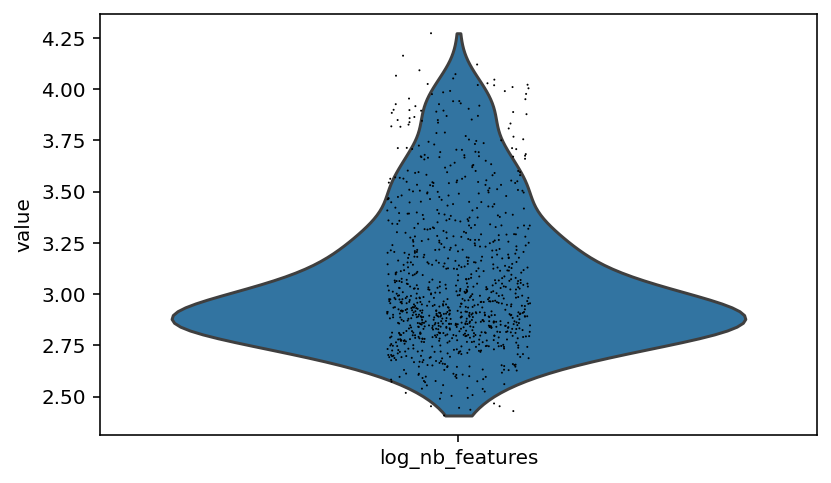

In [12]:
epi.pl.violin(adata, ["log_nb_features"])

In [13]:
X = adata.X
tfidf = TfidfTransformer(use_idf=True)
X_norm = tfidf.fit_transform(X)
adata.X = X_norm

In [14]:
sc.tl.pca(adata, zero_center=False, n_comps=51)

In [19]:
def remove_first_PC(adata):
    adata.obsm["X_pca_all"] = adata.obsm["X_pca"]
    adata.obsm["X_pca"] = adata.obsm["X_pca"][:,1:]
    adata.uns["pca"]["variance_ratio"] = adata.uns["pca"]["variance_ratio"][1:]
    adata.uns["pca"]["variance"] = adata.uns["pca"]["variance"][1:]
    return adata

In [20]:
remove_first_PC(adata)

AnnData object with n_obs × n_vars = 954 × 326252
    obs: 'nb_features', 'log_nb_features'
    var: 'n_cells'
    uns: 'pca'
    obsm: 'X_pca', 'X_pca_all'
    varm: 'PCs'

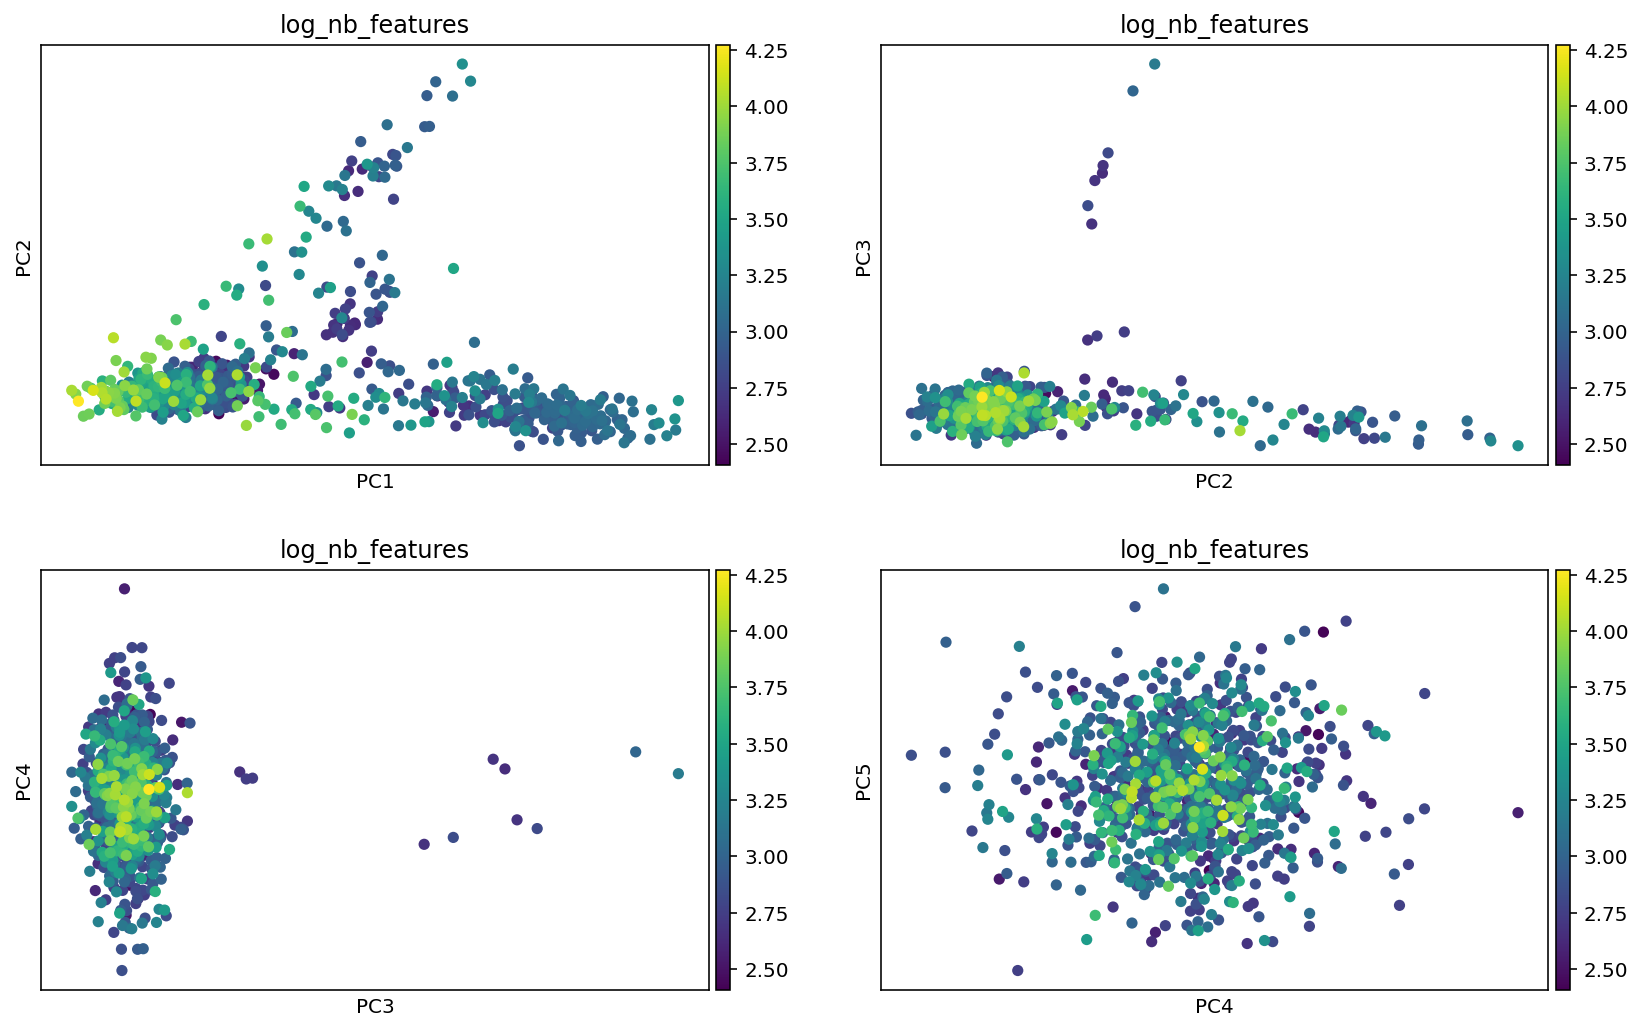

In [21]:
epi.pl.pca(adata, components=['1,2','2,3','3,4','4,5'], color="log_nb_features", ncols=2)

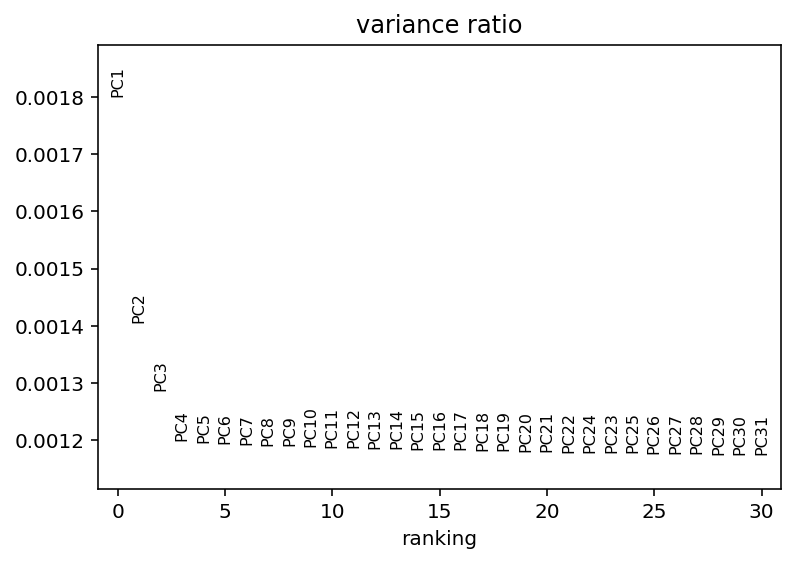

In [22]:
sc.pl.pca_variance_ratio(adata, n_pcs=30)

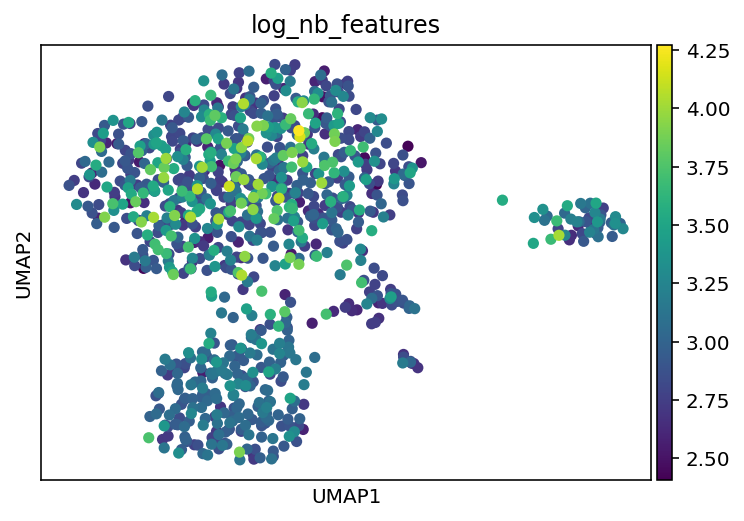

In [24]:
sc.tl.umap(adata, n_components=2)
sc.pl.umap(adata, color=["log_nb_features"])

In [27]:
epi.tl.rank_features(adata, 'louvain', omic='ATAC')

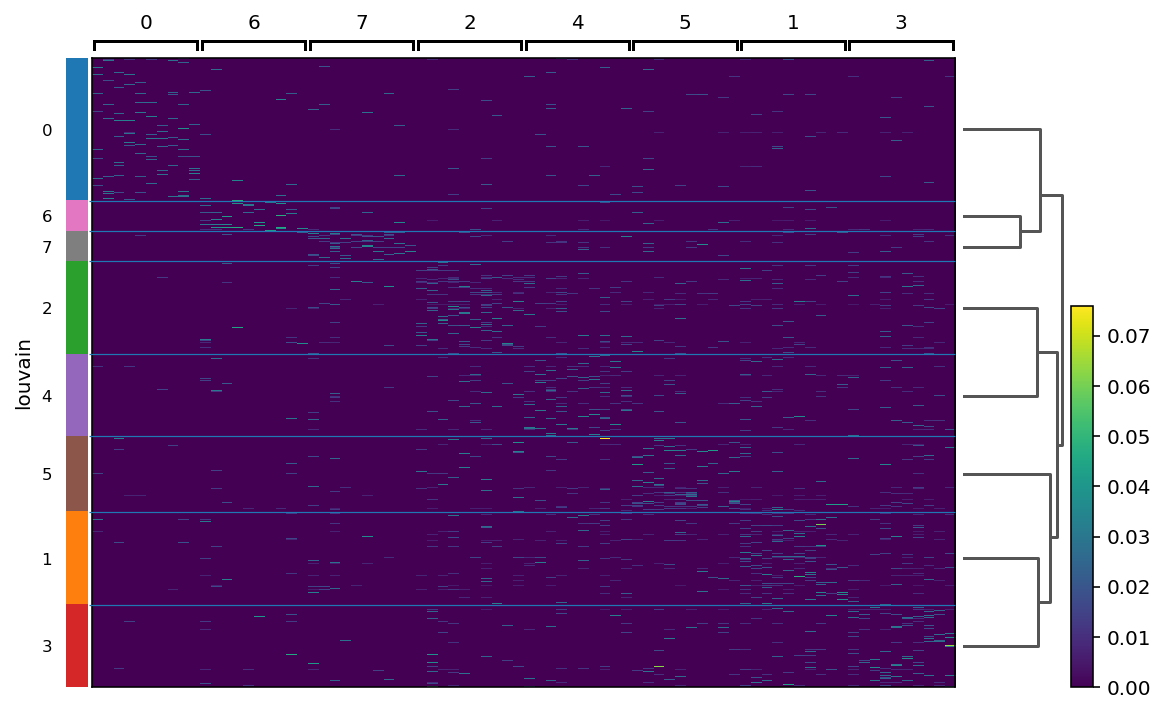

In [28]:
epi.pl.rank_feat_groups_heatmap(adata)

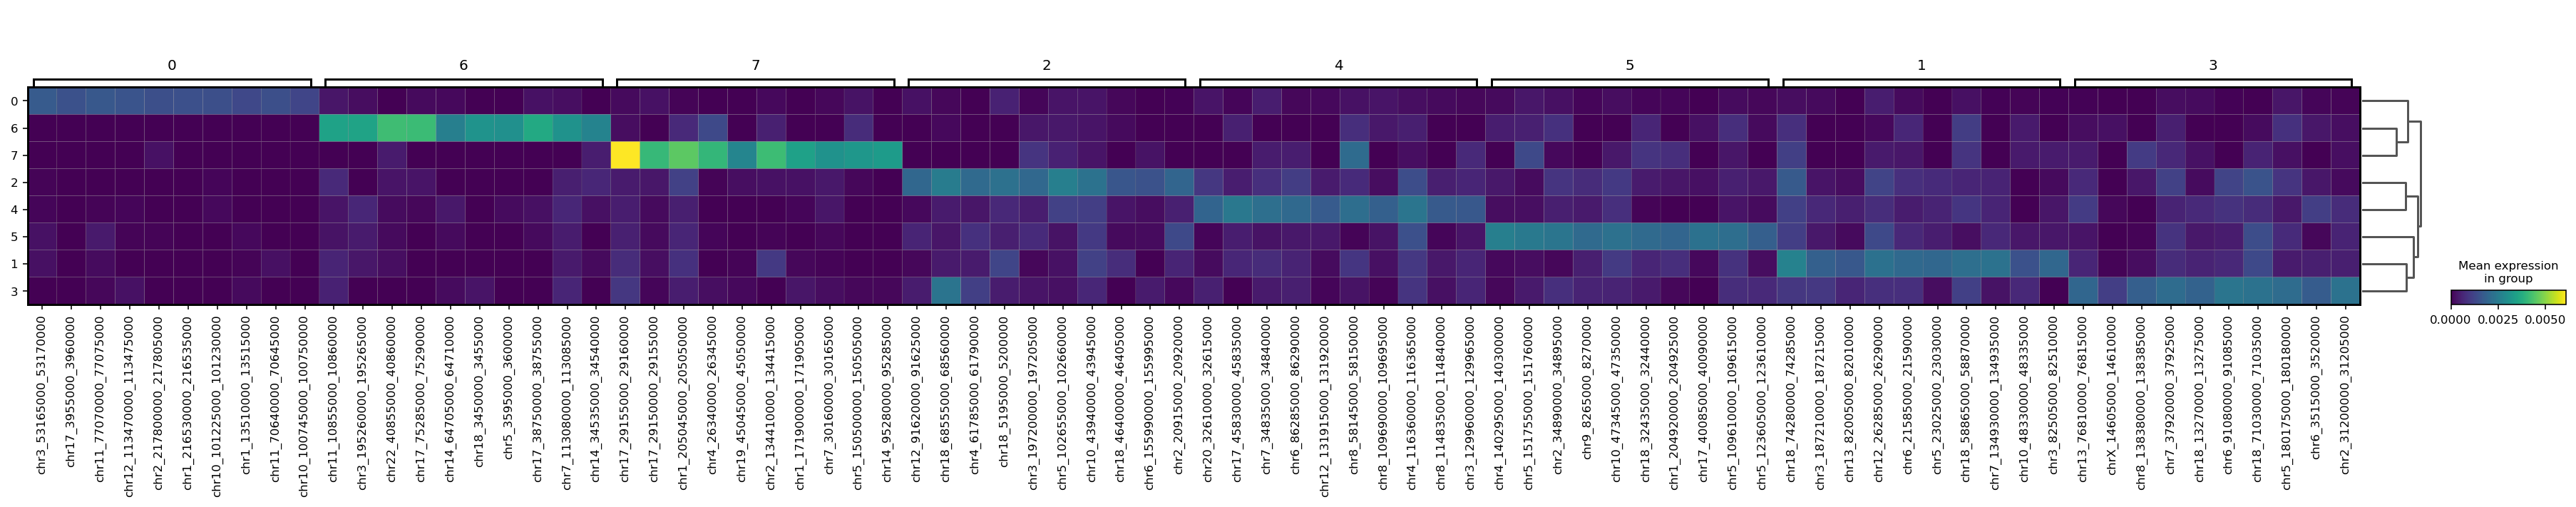

In [29]:
epi.pl.rank_feat_groups_matrixplot(adata)

In [25]:
epi.tl.louvain(adata)

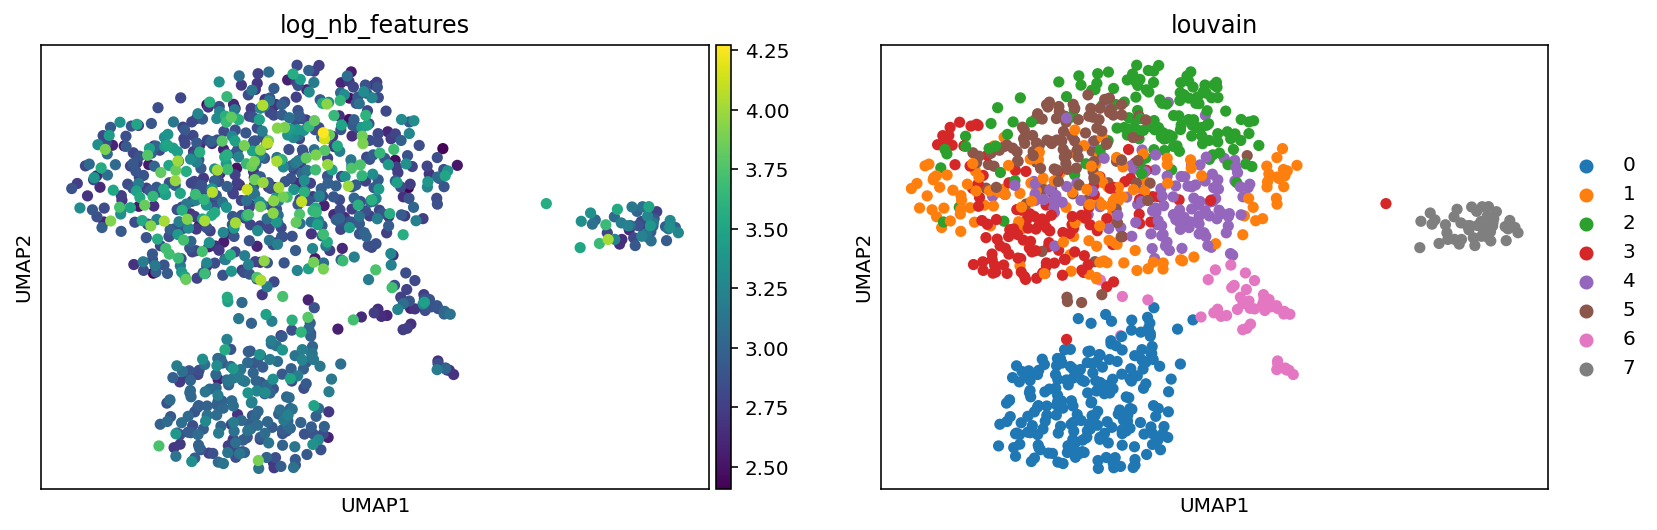

In [26]:
epi.pl.umap(adata, color=["log_nb_features", "louvain"])

In [54]:
adata.var

,n_cells,commonness,prop_shared_cells,variability_score
chr1_775000_780000,8.0,8.0,0.008386,0.508386
chr1_815000_820000,8.0,8.0,0.008386,0.508386
chr1_820000_825000,8.0,8.0,0.008386,0.508386
chr1_1155000_1160000,8.0,8.0,0.008386,0.508386
chr1_1205000_1210000,7.0,7.0,0.007338,0.507338
...,...,...,...,...
chrY_21840000_21845000,6.0,6.0,0.006289,0.506289
chrY_22220000_22225000,9.0,9.0,0.009434,0.509434
chrY_22290000_22295000,5.0,5.0,0.005241,0.505241
chrY_22365000_22370000,9.0,9.0,0.009434,0.509434


In [56]:
np.sort(adata.var["n_cells"])

array([  5.,   5.,   5., ..., 106., 112., 120.])

In [68]:
np.sort(adata.var["n_cells"])[-20000]

18.0

In [69]:
adata_20k = adata[:, adata.var["n_cells"] >= np.sort(adata.var["n_cells"])[-20000]]